## <u> Installing dependencies </u>

In [1]:
# !pip3 install torch-summary
# !pip install  torchmetrics #==0.5.1
# !pip3 install torchmetrics
# !pip3 install torchvision
# !pip3 install opencv-python
# !pip3 install -U scikit-image
# !pip3 install torchsummary

# !pip3 install prettytable



## <u> Imports </u>

In [2]:
import os, os.path
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from monai.losses.dice import DiceLoss
from monai.transforms import AsDiscrete
from monai.metrics import compute_iou, compute_dice
# import pandas as pd
# import imageio
import time
import random
from random import randint
import csv
import cv2
from skimage import io
from torchvision.datasets.folder import IMG_EXTENSIONS
import pickle as pkl
# from torchmetrics.functional import dice_score

from tqdm import tqdm


In [3]:
IMG_EXTENSIONS = (*IMG_EXTENSIONS, 'tif')
IMG_EXTENSIONS

('.jpg',
 '.jpeg',
 '.png',
 '.ppm',
 '.bmp',
 '.pgm',
 '.tif',
 '.tiff',
 '.webp',
 'tif')

In [4]:
# Make the environment deterministic
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Data Preprocessing

In [5]:
def comparative_debug(img1, img2):
    '''
    As a visual debugging tool, I usually plot images side by side to get an intuition of what's going on.
    '''
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.show()

Ca prim pas, intotdeauna ne uitam la datele cu care lucram pentru a intelege unde ar putea exista probleme.

Unique pixel values in the mask: [  0   8   9  10  11  12  13  14  15  16  17  18  19  21  22  23  24  25
  26  28  29  30  31  32  38  44  49  50  51  53  56  64  66  73  77  80
  82  85  88  91  96  98 112 255]


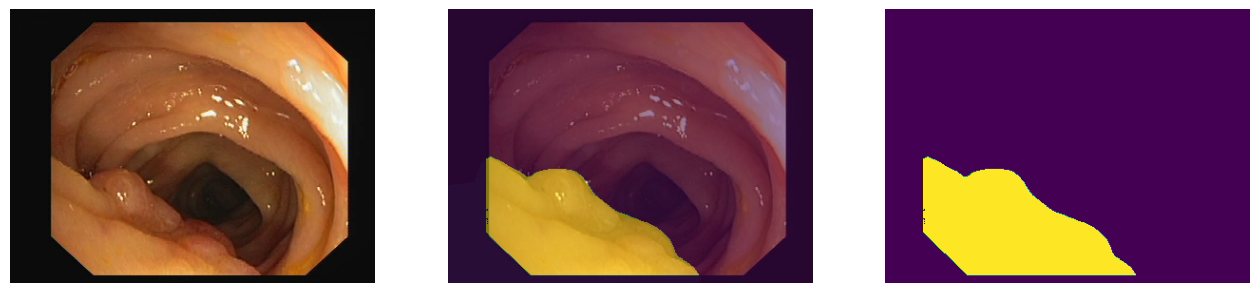

In [6]:

image_path = f'./train/og/1.tif'
mask_path =  f'./train/mask/1.tif'


debug_image  = io.imread(image_path)
debug_mask = io.imread(mask_path)

# Get the unique values in the image
uniques = np.unique(debug_mask)
print(f'Unique pixel values in the mask: {uniques}')

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].imshow(debug_image)
axes[1].imshow(debug_image)
axes[1].imshow(debug_mask, alpha=0.5)

a = debug_mask != 0
axes[2].imshow(debug_mask == 255)

# Set axis off
for ax in axes:
    ax.axis('off')

plt.axis('off')
plt.show()

Observam ca masca are valori intre 0 si 255.

Trecand prin valorile unice din masca, intuim ca labelurile nu sunt exacte.

Asadar avem nevoie de o functie care sa pregateasaca masca pentru un task de segmentare cu 2 clase:
* Trecem toti pixelii din intervalul [0, 255] in [0, 1] aplicand o normalizare MinMax
* Stabilim un threshold pentru a separa cele doua clase (De obicei acest threshold se poate trata ca un hyperparametru la antrenare)
* Dupa aceea, in mod normal, spargem masca in N+1 canale, unde N este numarul de clase, pentru a forta modelul sa diferentieze de background.

In [7]:
def min_max_normalization(image):
    '''
    Min-max normalization is a common technique used in computer vision to normalize the pixel values of an image.
    '''
    image = (image - image.min()) / (image.max() - image.min())

    # If the image is a tensor image.float, else image.astype(np.float32)
    if isinstance(image, torch.Tensor):
        image = image.float()
    elif isinstance(image, np.ndarray):
        image = image.astype(np.float32)
        
    return image


def binarize_input(mask, threshold=0.5):
    '''
    Normalizes the input using min-max normalization and then binarizes it using the mean
    '''
    mask = min_max_normalization(mask)

    min_val = mask.min()
    max_val = mask.max()

    threshold = (min_val + max_val) / 2

    mask[mask < threshold] = min_val
    mask[mask >= threshold] = max_val
    
    return mask


torch.Size([288, 384])


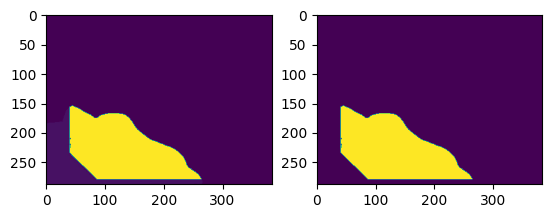

In [8]:
gt = binarize_input(torch.tensor(debug_mask))
print(gt.shape)

# Create 2 subplots one with the original image and one with the mask
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(debug_mask)
ax2.imshow(gt)
plt.show() 

### HYPERPARAMETERS

In [9]:
BATCH_SIZE = 4

### Data Augmentations

In ceea ce priveste taskurile de segmentare, trebuie sa avem grija sa aplicam aceleasi transformari atat pe imagine cat si pe masca.

Totusi, pentru transformarile care modifica intesitatea pixelilor (precum CollorJitter, Contrast sau IntensityScaling) augmentarea se aplica doar asupra imaginii.

Un alt aspect de care trebuie sa tinem cont este coeziunea dintre datele de intrare si cele de iesire. 

De exemplu, daca aplicam o tehnica de resize sau de imbunatatire a contrastului, trebuie sa ne asiguram ca aceeasi transformare este aplicata si datelor de test. 

Altfel, riscam ca reteaua antrenata de noi sa nu fie relevanta pentru imaginile din setul de testare.


In [10]:
# Augmentarea datelor de dinaintea aplicarii tehnicii de CutMix
cutmix_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((240, 240)),

        # Cateodata se foloseste normalizarea pixelilor pe baza setului de date ImageNet
        # In medical imaging, totusi este nepotrivit deoarece exista un shift de distributie
        # torchvision.transforms.Normalize(mean=mean_imgnet, std=std_imgnet), 

    ])

# Inlantuire in care adaugam mai multe transformari de date
train_common_transform = torchvision.transforms.Compose([
        cutmix_transform,
        torchvision.transforms.RandomRotation(30)
    ]
    )

# Transformari de intensitate aplicate doar pe imagini
train_img_transform = torchvision.transforms.Compose([
        # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])


test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((240, 240)),
        train_img_transform
        # torchvision.transforms.Normalize(mean=mean_imgnet, std=std_imgnet),
    ])


In [11]:
class cvcTrain(Dataset):
    def __init__(self, dataset_path, common_transform=None, img_transform=None, cutmix_transform=None, debug_flag=False):
        self.dataset_path = dataset_path
        self.length = len(os.listdir(dataset_path + "og"))
        
        self.common_transform = common_transform
        self.img_transform = img_transform
        self.cutmix_transform = cutmix_transform
        self.mask_transform = AsDiscrete(to_onehot=2)

        self.debug_mode = debug_flag

    def get_img_and_mask(self, index):
        '''
        Helper function to get the image and the mask from the hard drive
        '''

        img_path = f'{self.dataset_path}og/{str(index + 1)}.tif'
        img = io.imread(img_path)
        # print(img.shape)

        mask_path = f'{self.dataset_path}mask/{str(index + 1)}.tif'
        mask = io.imread(mask_path)
        return img, mask


    def mask_or_cutmix(self, img, mask):
        '''
        Based on a random choice, either leaves the image and mask as they are, or applies a mask augmentation or CutMix
        '''

        augment_type = random.randint(0, 2)

        # No augmentation
        if augment_type == 0:
            return img, mask
        
        height_og, width_og = img.shape[1], img.shape[2]

        # Mask augmentation
        if augment_type == 1:
            mask_width = random.randint(20, 60)

            starting_i = random.randint(0, height_og - mask_width)
            starting_j= random.randint(0, width_og - mask_width)

            img[:, starting_i:starting_i+mask_width, starting_j:starting_j+mask_width] = 0
            mask[:, starting_i:starting_i+mask_width, starting_j:starting_j+mask_width] = 0
            return img, mask
        
        # CutMix augmentation
        if augment_type == 2 and self.cutmix_transform is not None:
            mask_width = random.randint(20, 80)

            starting_i = random.randint(0, height_og - mask_width)
            starting_j= random.randint(0, width_og - mask_width)


            index = random.randint(0, self.length - 1)
            img2, mask2 = self.get_img_and_mask(index)
            img2, mask2 = self.cutmix_transform(img2), self.cutmix_transform(mask2)

            img[:, starting_i:starting_i+mask_width, starting_j:starting_j+mask_width] = img2[:, starting_i:starting_i+mask_width, starting_j:starting_j+mask_width]
            mask[:, starting_i:starting_i+mask_width, starting_j:starting_j+mask_width] = mask2[:, starting_i:starting_i+mask_width, starting_j:starting_j+mask_width]

            return img, mask
        else:
            return img, mask


    def __getitem__(self, index):
        if index >= 0 and index < self.length:
            img, mask = self.get_img_and_mask(index)

            # Random seeds are used to ensure that the same transformation is applied to both the image and the mask
            if self.common_transform is not None:
                # seed = random.randint(0,2**32)
                random.seed(seed)   
                torch.manual_seed(seed)

                img = self.common_transform(img)

                random.seed(seed)
                torch.manual_seed(seed)
                mask = self.common_transform(mask)

            if self.cutmix_transform is not None:
                img, mask = self.mask_or_cutmix(img, mask)
            
            if self.img_transform is not None:
                img = self.img_transform(img)

            
            if self.debug_mode:
                comparative_debug(img.squeeze(), mask)


            img = min_max_normalization(img)
            mask = binarize_input(torch.tensor(mask))
            return img, self.mask_transform(mask)
        else:
            raise IndexError('Index out of bounds')

    def __len__(self):
        return self.length


In [12]:
dataset_folder = './train/'
train_dataset = cvcTrain(dataset_path=dataset_folder, common_transform=train_common_transform, img_transform=train_img_transform, cutmix_transform=cutmix_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([2, 240, 240])
torch.Size([2, 240, 240])


/tmp/ipykernel_62205/1039148874.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = binarize_input(torch.tensor(mask))


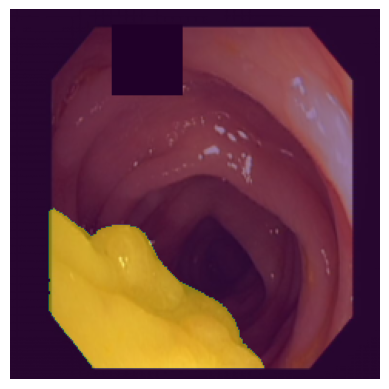

In [13]:
img, gt = train_dataset[0]

print(gt.shape)
mask = gt
print(mask.shape)

plt.imshow(img.numpy().transpose(1, 2, 0))
plt.imshow(mask[1], alpha=0.5)

# remove axis
plt.axis('off')
plt.show()

In [14]:
class cvcTest(Dataset):
    def __init__(self, dataset_path, save_path, common_transform=None, img_transform=None):
        self.dataset_path = dataset_path
        self.length = len(os.listdir(dataset_path + "og"))
        
        self.save_path = save_path
        self.common_transform = common_transform
        self.img_transform = img_transform
        self.mask_transform = AsDiscrete(to_onehot=2)
        
    def __getitem__(self, index):
        if index >= 0 and index < self.length:
            img_path = f'{self.dataset_path}og/{str(index + 1)}.tif'
            img = io.imread(img_path)

            mask_path = f'{self.dataset_path}mask/{str(index + 1)}.tif'
            mask = io.imread(mask_path)

            path_save = self.save_path + str(index + 1) + '.tif'        

            # Random seeds are used to ensure that the same transformation is applied to both the image and the mask
            if self.common_transform is not None:
                # seed = random.randint(0,2**32)
                random.seed(seed)   
                torch.manual_seed(seed)

                img = self.common_transform(img)

                random.seed(seed)
                torch.manual_seed(seed)
                mask = self.common_transform(mask)

            if self.img_transform is not None:
                img = self.img_transform(img)
        

            return img, self.mask_transform(binarize_input(torch.tensor(mask))), path_save
        else:
            raise IndexError('Index out of bounds')

    def __len__(self):
        return self.length


In [15]:
val_path = './val/'
test_dataset = cvcTest(dataset_path=val_path, save_path='./pred/UNet/', common_transform=test_transform, img_transform=train_img_transform)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(len(test_dataset))

127


### Network

In [16]:
def get_prediction(output):
    '''
    The output of the model is a tensor of shape [BATCH_SIZE, 2, 240, 240]
    The function aggregates the channels to enhance tumor detection and returns a tensor of shape [BATCH_SIZE, 240, 240]
    '''

    threshold = 0.5

    output_bg = output[:, 0, :, :]
    output_bg = binarize_input(output_bg, threshold)

    output_fg = output[:, 1, :, :]
    output_fg = binarize_input(output_fg, threshold)

    output = (1 - output_bg) * output_fg

    return output.float().unsqueeze(1).clone()


In [17]:
# Reference: https://github.com/masontchen/unet_polyp_segmentation/blob/master/U-Net-aug.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # start with 240
        self.enc1conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc1conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc1pool1 = nn.MaxPool2d(2, 2)  # 120
        
        self.enc2conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc2conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.enc2pool2 = nn.MaxPool2d(2, 2)  # 60
        
        self.enc3conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc3conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.enc3pool3 = nn.MaxPool2d(2, 2)  # 30
        
        self.enc4conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.enc4conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.enc4pool4 = nn.MaxPool2d(2, 2)  # 15
        
        self.enc5conv9 = nn.Conv2d(512, 1024, 3, padding=1)
        self.enc5conv10 = nn.Conv2d(1024, 1024, 3, padding=1)

        self.dec4conv11 = nn.ConvTranspose2d(1024, 512, 2, stride=2)  # 30
        self.dec4conv12 = nn.Conv2d(1024, 512, 3, padding=1)
        self.dec4conv13 = nn.Conv2d(512, 512, 3, padding=1)

        self.dec3conv14 = nn.ConvTranspose2d(512, 256, 2, stride=2)  # 60
        self.dec3conv15 = nn.Conv2d(512, 256, 3, padding=1)
        self.dec3conv16 = nn.Conv2d(256, 256, 3, padding=1)

        self.dec2conv17 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 120
        self.dec2conv18 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec2conv19 = nn.Conv2d(128, 128, 3, padding=1)

        self.dec1conv20 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 240
        self.dec1conv21 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec1conv22 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec1conv23 = nn.Conv2d(64, 2, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder Layer 1
        x = F.relu(self.enc1conv2(F.relu(self.enc1conv1(x))))
        x1_dup = x # Residual connection
        x = self.enc1pool1(x)

        # Encoder Layer 2
        x = F.relu(self.enc2conv4(F.relu(self.enc2conv3(x))))
        x2_dup = x # Residual connection
        x = self.enc2pool2(x)

        # Encoder Layer 3
        x = F.relu(self.enc3conv6(F.relu(self.enc3conv5(x))))
        x3_dup = x
        x = self.enc3pool3(x)

        # Encoder Layer 4
        x = F.relu(self.enc4conv8(F.relu(self.enc4conv7(x))))
        x4_dup = x
        x = self.enc4pool4(x)
        
        # Encoder Layer 5 - Bottom of the U
        x = F.relu(self.enc5conv10(F.relu(self.enc5conv9(x))))
        
        # Decoder Layer 4 - Bottom of the U
        x = self.dec4conv11(x)
        x = torch.cat((x4_dup, x), 1)
        x = F.relu(self.dec4conv12(x))
        x = F.relu(self.dec4conv13(x))

        # Decoder Layer 3
        x = self.dec3conv14(x)
        x = torch.cat((x3_dup, x), 1)
        x = F.relu(self.dec3conv15(x))
        x = F.relu(self.dec3conv16(x))

        # Decoder Layer 2
        x = self.dec2conv17(x)
        x = torch.cat((x2_dup, x), 1)
        x = F.relu(self.dec2conv18(x))
        x = F.relu(self.dec2conv19(x))

        # Decoder Layer 1
        x = self.dec1conv20(x)
        x = torch.cat((x1_dup, x), 1)
        x = F.relu(self.dec1conv21(x))
        x = F.relu(self.dec1conv22(x))
        x = self.dec1conv23(x)

        x = self.sigmoid(x)

        # print(x.shape)
        # x = get_prediction(x)
        return x
    
    def save(self, name):
        torch.save(self.state_dict(), name)
        print("Model saved")

    @staticmethod
    def load(name):
        model = Net()
        model.load_state_dict(torch.load(name))
        return model

In [18]:
epochs = 15
learning_rate = 5e-5

regularization_factor = 0.2

net = Net().cuda()

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)

lossfn = torch.nn.BCELoss()
# lossfn = DiceLoss(include_background=False)
# lossl1 = torch.nn.L1Loss()
lossl1 = torch.nn.KLDivLoss()

loss_log = []
loss_history = []

In [19]:
# debug_batch = next(iter(train_loader))

# debug_batch_img, debug_batch_mask = debug_batch

# a = net(debug_batch_img.cuda())

# print(a.shape, debug_batch_mask.shape)

# lossfn(a, debug_batch_mask.cuda())

### Evaluation Metrics:

In [20]:
torch.autograd.set_detect_anomaly(True)

In [34]:
def eval(net, val_loader, lossfn):
    '''
    At VALIDATION_STEP epochs, the model is evaluated quantitatively on the validation set
    '''

    val_loss = []
    val_dice_score = []
    iou_score = []

    with torch.no_grad():
        for val_batch in val_loader:
            val_img, val_gt = val_batch
            val_img, gt = val_img.cuda(), val_gt.cuda()

            output = net(val_img)

            output_fg = output[:, 1, :, :]
            gt_fg = gt[:, 1, :, :]

            loss = lossfn(output_fg, gt_fg)
            val_loss.append(loss.data.item())

            batch_dices = compute_dice(output, gt, include_background=False)
            batch_iou = compute_iou(output, gt, include_background=False)

            val_dice_score.append(batch_dices.mean().cpu())
            iou_score.append(batch_iou.mean().cpu())



    val_mean_loss = np.mean(val_loss)
    val_mean_dice_score = np.mean(val_dice_score)
    val_mean_iou_score = np.mean(iou_score)

    print(f'Validation loss: {val_mean_loss}')
    print(f'Validation dice score: {val_mean_dice_score:.5f}')
    print(f'Validation iou score: {val_mean_iou_score:.5f}')

    return val_mean_loss, val_mean_dice_score, val_mean_iou_score
    

def train(checkpoint_name : str, train_loader, val_loader, optimizer, lossfn, BATCH_SIZE : int, NO_EPOCHS : int, VALIDATION_STEP : int, learning_rate : float, regularization_factor : float):
    custom_loss = False # True

    net_name = f'unet_{checkpoint_name}_batchsize{BATCH_SIZE}_{NO_EPOCHS}epochs_{learning_rate:.2E}'

    best_net = None
    best_loss = 1e9

    for epoch in range(1, NO_EPOCHS+1):
        print(f"\nEpoch number {epoch}/{NO_EPOCHS}")

        step = 0
        for data in train_loader:
            image1, gt = data
            image1, gt = image1.cuda(), gt.cuda()
            
            output = net(image1)
            optimizer.zero_grad()

            output_fg = output[:, 1, :, :]
            gt_fg = gt[:, 1, :, :]


            if custom_loss:
                loss = lossfn(output_fg, gt_fg) + regularization_factor * lossl1(output_fg, gt_fg)
            else:
                loss = lossfn(output_fg, gt_fg)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.step()
            loss_log.append(loss.data.item())

            print(f"Step {step} loss: {loss.data.item()}")
            step += 1
        

        epoch_mean_loss = np.mean(loss_log[-step:])
        print(f"Epoch loss: {epoch_mean_loss}")

        loss_history.append(epoch_mean_loss)

        # In mod normal sa valideaza pe testul de validare si se testeaza pe testul de testare
        # Pentru a mentine tutorialul in limitele de timp, vom valida pe testul de testare
        if epoch % VALIDATION_STEP == 0 and epoch != 0:
            val_mean_loss, _, _ = eval(net, val_loader, lossfn)

            if val_mean_loss < best_loss:
                best_loss = val_mean_loss
                best_net = net
            
            net.save(f'unet_{checkpoint_name}_batchsize{BATCH_SIZE}_{epoch}epochs_{learning_rate:.2E}_w_aug')

    net.save(net_name)
    best_net.save(f'{net_name}_best')

    pkl.dump(loss_log, open(f'{net_name}_loss_journal.pkl', 'wb'))

    return net, net_name, loss_log, loss_history


In [22]:
net, net_name, loss_log, loss_history = train('bce', train_loader, train_loader, optimizer, lossfn, BATCH_SIZE, epochs, 2, learning_rate, regularization_factor)


Epoch number 1/15


/tmp/ipykernel_62205/1039148874.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = binarize_input(torch.tensor(mask))


Step 0 loss: 0.7223867177963257
Step 1 loss: 0.7207750082015991
Step 2 loss: 0.7211254239082336
Step 3 loss: 0.7195193767547607
Step 4 loss: 0.7168154120445251
Step 5 loss: 0.7181273698806763
Step 6 loss: 0.7125318646430969
Step 7 loss: 0.7145558595657349
Step 8 loss: 0.7150182723999023
Step 9 loss: 0.7139438390731812
Step 10 loss: 0.7121759653091431
Step 11 loss: 0.7116847634315491
Step 12 loss: 0.70917809009552
Step 13 loss: 0.7051882743835449
Step 14 loss: 0.710161566734314
Step 15 loss: 0.7070217728614807
Step 16 loss: 0.7063795328140259
Step 17 loss: 0.7034422159194946
Step 18 loss: 0.7021028995513916
Step 19 loss: 0.7011934518814087
Step 20 loss: 0.7000842690467834
Step 21 loss: 0.6991227865219116
Step 22 loss: 0.6972836256027222
Step 23 loss: 0.6974033713340759
Step 24 loss: 0.6940935254096985
Step 25 loss: 0.6914635896682739
Step 26 loss: 0.6902744770050049
Step 27 loss: 0.6881703734397888
Step 28 loss: 0.6857612133026123
Step 29 loss: 0.6802322268486023
Step 30 loss: 0.6829856

In [35]:
len(loss_log) // epochs,  len(train_dataset) // BATCH_SIZE

(122, 121)

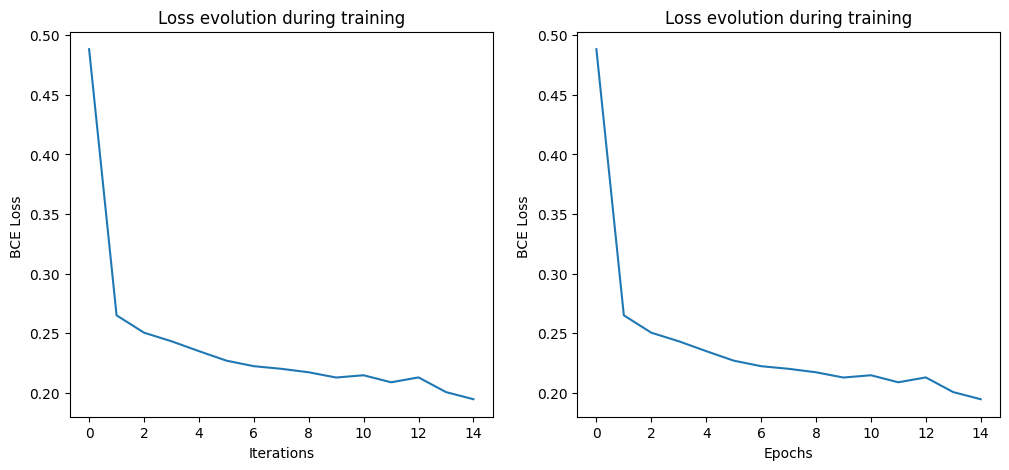

In [36]:
# Plot loss-evolution during training
def plot_loss_evolution(epochs, loss_history, metric, phase, net_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.title(f'Loss evolution during {phase}')
    
    plt.subplot(1, 2, 2)
    loss_history = np.array(loss_history)
    loss_by_epochs = []

    
    step = len(loss_history) // epochs

    for i in range(epochs):
        loss_by_epochs.append(np.mean(loss_history[i*step:(i+1)*step]))

    plt.plot(range(epochs), loss_by_epochs)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'Loss evolution during {phase}')
    plt.savefig(f'loss_evolution_{phase}_{net_name}.png')
    # plt.show()

plot_loss_evolution(epochs, loss_history, 'BCE Loss ', 'training', net_name)

In [37]:
def qualitative_evaluation(image, output, ground_truth):
    '''
    Create 2 subplots one with the original image and the overlapped ground truth mask and one with the predicted mask
    '''

    mini_img = image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    mini_gt = ground_truth[1].cpu().detach().numpy()
    mini_output = output[1].cpu().detach().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(mini_img)
    axes[0].imshow(mini_gt, alpha=0.5)
    axes[0].set_title('Ground truth')
    axes[1].imshow(mini_img)
    axes[1].imshow(mini_output, alpha=0.5)
    axes[1].set_title('Predicted mask')

    # remove axis
    for ax in axes:
        ax.axis('off')
    plt.show()

/tmp/ipykernel_62205/4093973966.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, self.mask_transform(binarize_input(torch.tensor(mask))), path_save


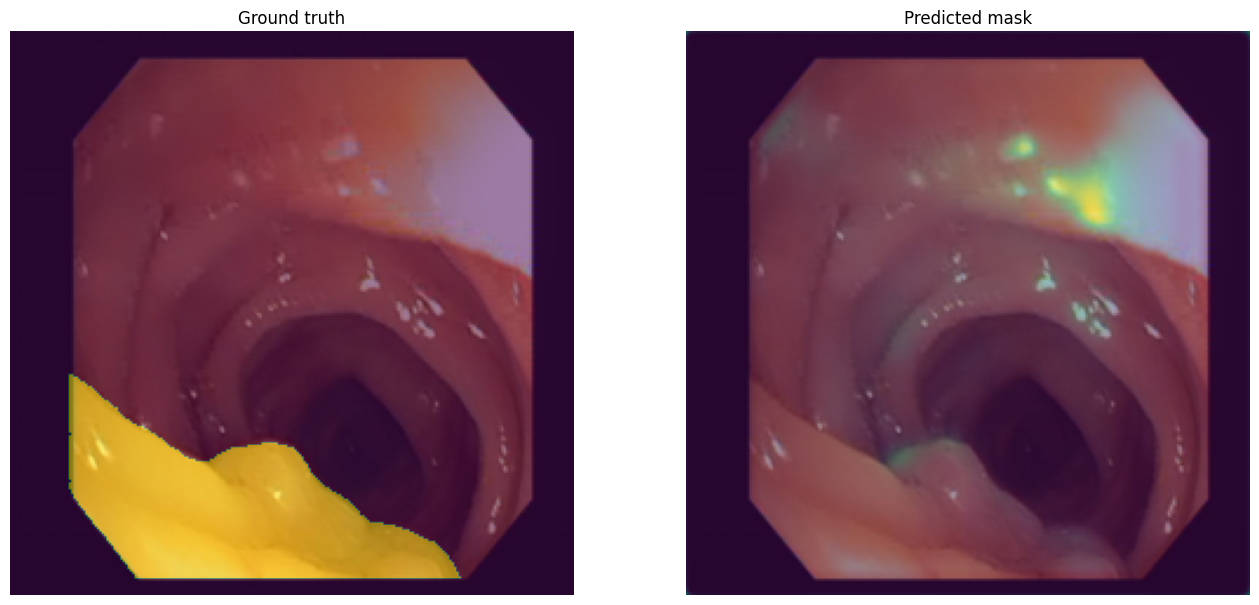

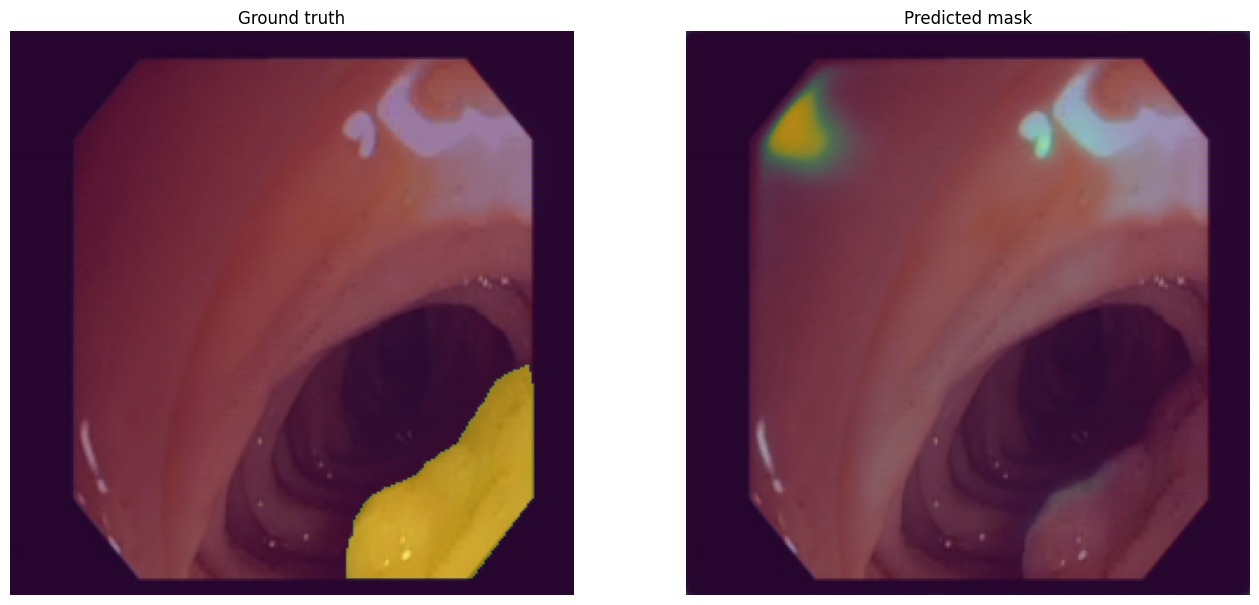

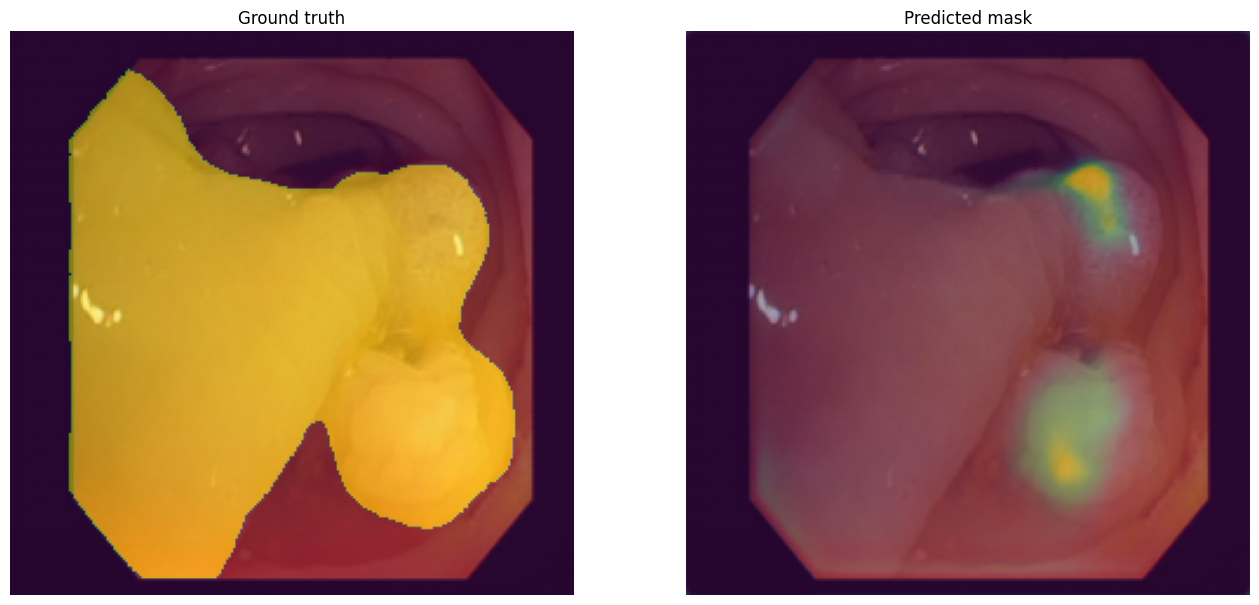

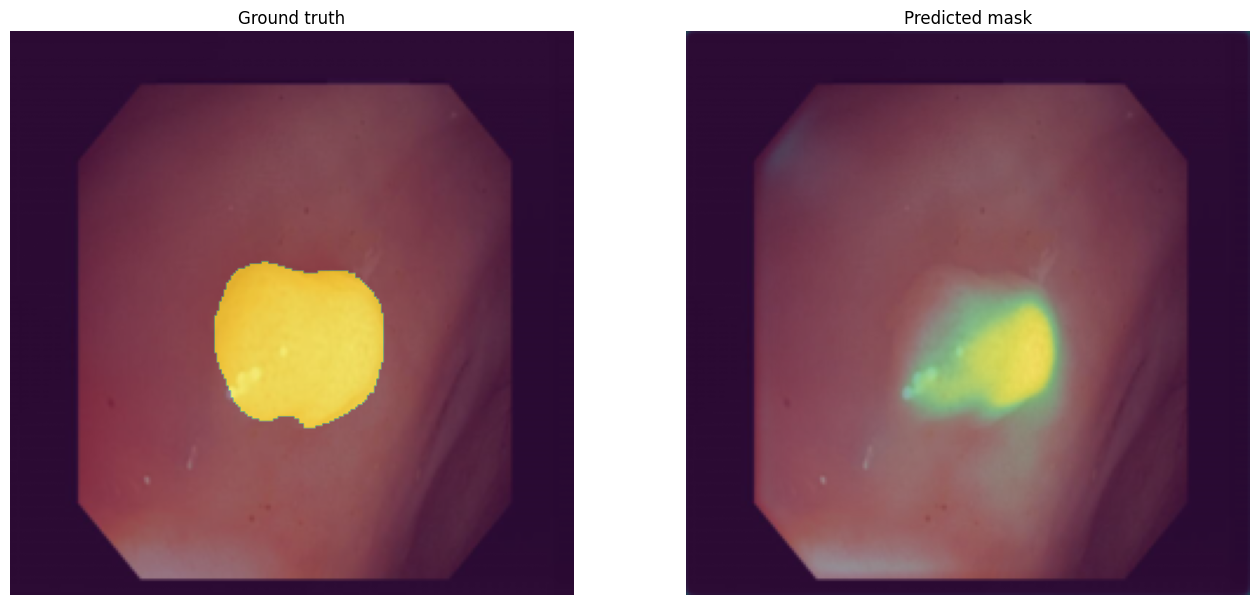

Validation loss: 0.5198812708258629
Validation dice score: 0.14707
Validation iou score: 0.18382


In [38]:
net = Net.load(net_name).to('cuda')

val_loss = []
val_dice_score = []
iou_score = []

# jacard = BinaryJaccardIndex()

one_round_of_qualitative = True

with torch.no_grad():
  for data in val_loader:
            image1, gt, _ = data
            image1, gt = image1.cuda(), gt.cuda()

            # print(image1.shape)
            # print(net(image1).shape)

            output = net(image1)

            if one_round_of_qualitative:
              for k in range(output.shape[0]):
                qualitative_evaluation(image1[k], output[k], gt[k])
              one_round_of_qualitative = False

            loss = lossfn(output, gt) # + regularization * lossl1(output, gt)
            val_loss.append(loss.data.item())

            batch_dices = compute_dice(output, gt, include_background=False)
            batch_iou = compute_iou(output, gt, include_background=False)

            val_dice_score.append(batch_dices.mean().cpu())
            iou_score.append(batch_iou.mean().cpu())

print(f'Validation loss: {np.mean(val_loss)}')
print(f'Validation dice score: {np.mean(val_dice_score):.5f}')
print(f'Validation iou score: {np.mean(iou_score):.5f}')

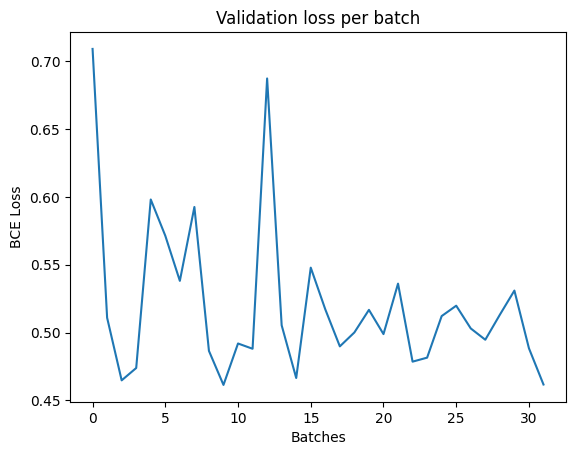

In [39]:
plt.plot(val_loss)
plt.xlabel('Batches')
plt.ylabel('BCE Loss')
plt.title('Validation loss per batch')
plt.show()


/tmp/ipykernel_62205/4093973966.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, self.mask_transform(binarize_input(torch.tensor(mask))), path_save


Max value: 1.0
(2, 240, 240)


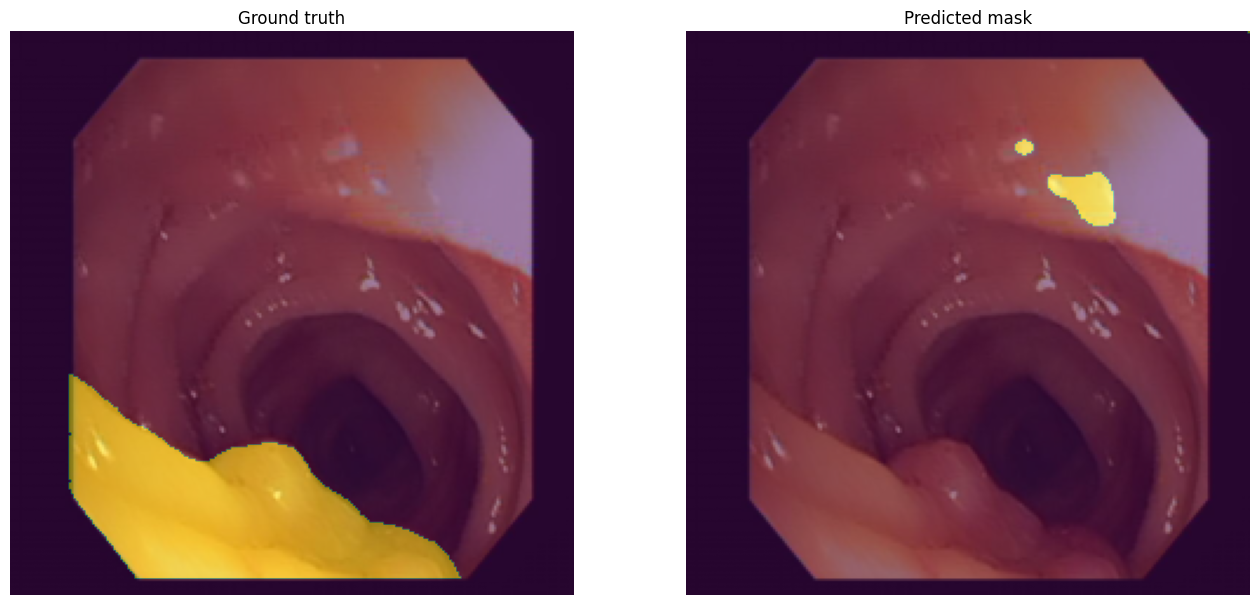

Max value: 1.0
(2, 240, 240)


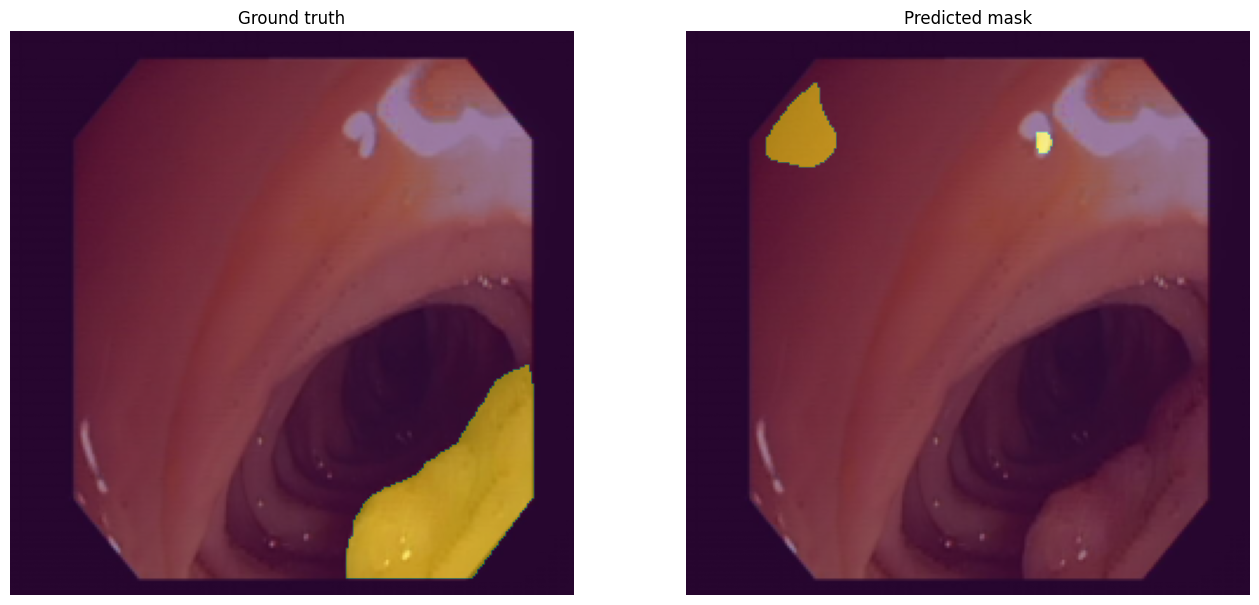

Max value: 1.0
(2, 240, 240)


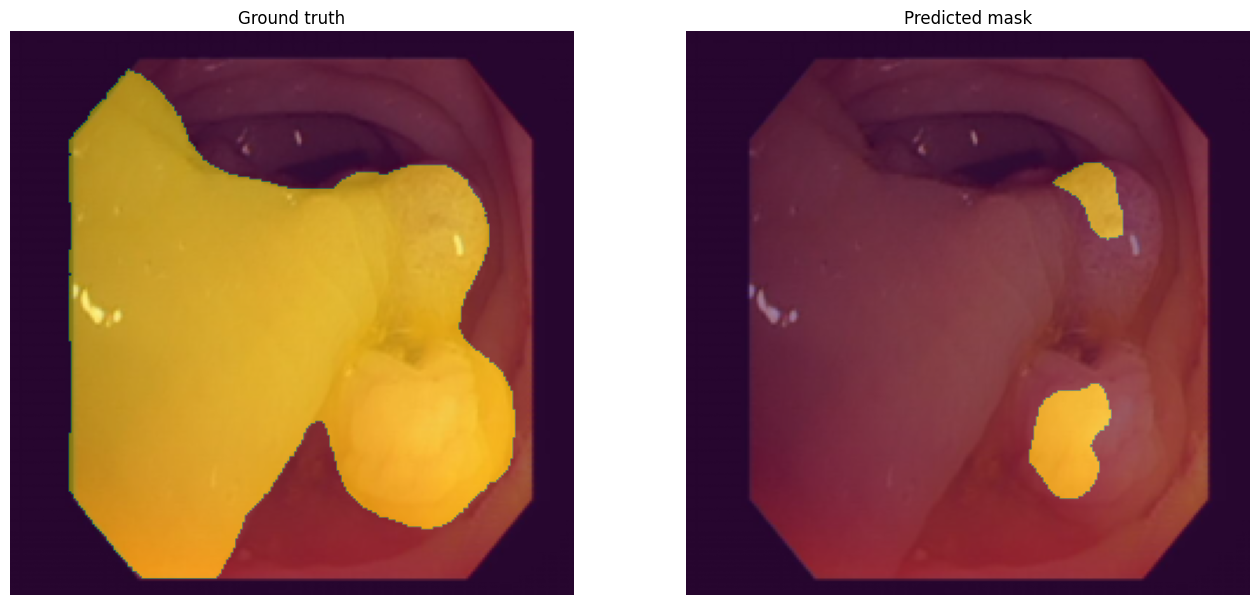

Max value: 1.0
(2, 240, 240)


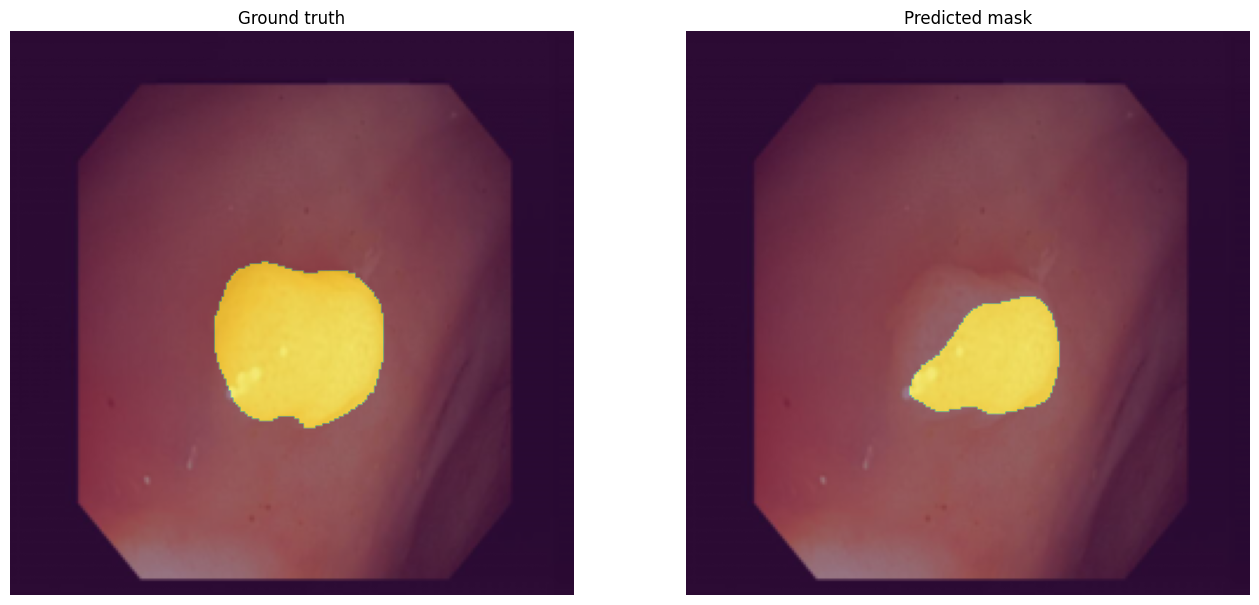

Max value: 1.0
(2, 240, 240)


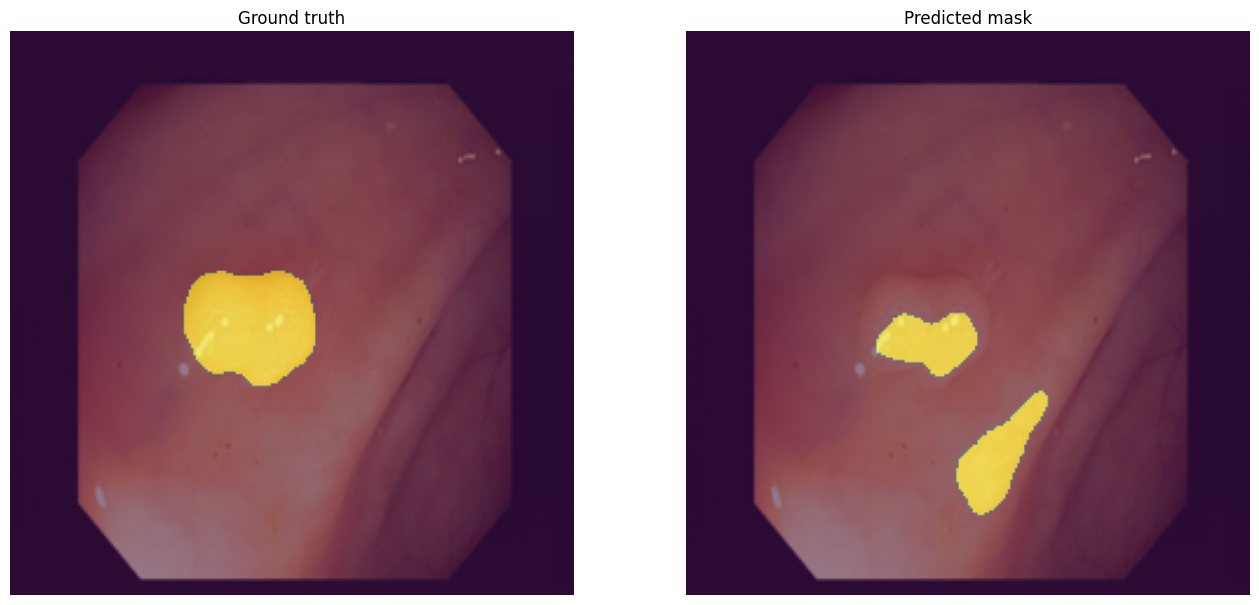

Max value: 1.0
(2, 240, 240)
Max value: 1.0
(2, 240, 240)
Max value: 1.0
(2, 240, 240)
Max value: 1.0
(2, 240, 240)
Max value: 1.0
(2, 240, 240)
Max value: 1.0
(2, 240, 240)
Max value: 1.0
(2, 240, 240)


OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 

In [41]:
import sys

num_files = len([name for name in os.listdir('./val/og/')])

if not os.path.exists('./pred/UNet/'):
    os.makedirs('./pred/UNet/')


max_prints = 5

for data in val_loader:
    image1, gt, path_save = data
    image1, gt = Variable(image1).cuda(), Variable(gt).cuda()

    output = net(image1)
    output = output.cpu()

    for i in range(output.shape[0]):
        crt_output = output[i].squeeze()
        crt_output = binarize_input(crt_output)
        print(f"Max value: {crt_output.max()}")



        # crt_output = torch.round(softmax_layer(crt_output))
        # print(f"Max value: {crt_output.max()}")
        
        polyp = output.data.numpy()[i].squeeze() * 255


        print(polyp.shape)
        
        # comparative_debug(gt[:, 1, :, :].cpu().data.numpy()[i].squeeze(), polyp[1, :, :])
        if max_prints > 0:
            qualitative_evaluation(image1[i], crt_output, gt[i])
            max_prints -= 1

        io.imsave(path_save[i], polyp[1, :, :].astype(np.uint8))

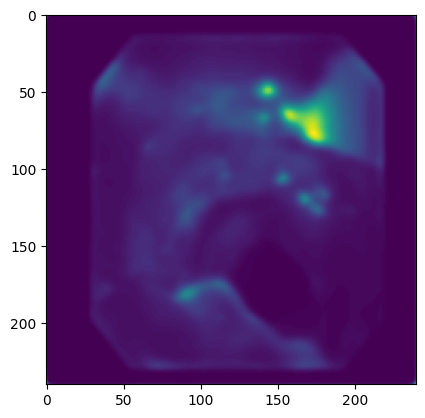

In [29]:
plt.imshow(io.imread('./pred/UNet/1.tif'))
plt.show()

Random index:  99
torch.Size([3, 240, 240]) torch.Size([240, 240])


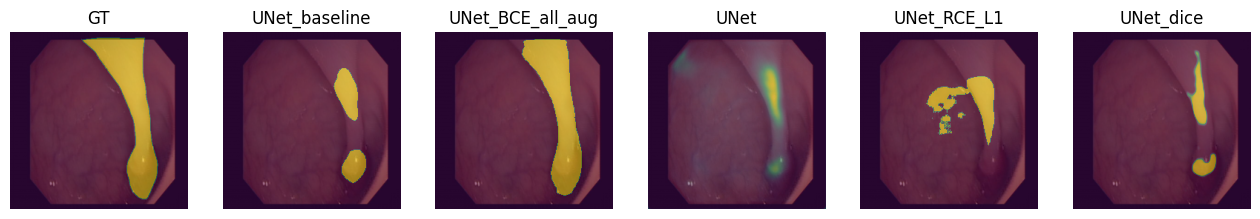

In [30]:
for i in range(1, 128):

    idx = random.randint(1, 128)
    i = 19
    print("Random index: ", idx)

    img = io.imread(f'./val/og/{i}.tif')
    img = cutmix_transform(img)

    gt = io.imread(f'./val/mask/{i}.tif')
    gt = cutmix_transform(gt).squeeze() 

    masks = [('GT', gt)]

    print(img.shape, gt.shape)

    for crt_folder in os.listdir('./pred/'):
        searching_for_file = f'./pred/{crt_folder}/{i}.tif'
        if os.path.isfile(searching_for_file):
            masks.append((crt_folder, io.imread(searching_for_file)))

    fig, axes = plt.subplots(1, len(masks), figsize=(16, 8))

    for i, ax in enumerate(axes):
        ax.axis('off')
        ax.set_title(masks[i][0])
        ax.imshow(img.numpy().transpose(1, 2, 0))
        ax.imshow(masks[i][1], alpha=0.5)


        
    plt.show()

    break


In [31]:
# Clear gpu memory
# View cuda memory usage in GB
memory = torch.cuda.memory_allocated()
print(f"Memory allocated: {memory / 1e9}GB")

Memory allocated: 1.203387392GB


In [32]:
net = Net().cuda()

# NET SUMMARY
from torchsummary import summary
summary(net, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5        [-1, 128, 112, 112]         147,584
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Conv2d-8          [-1, 256, 56, 56]         590,080
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
           Conv2d-11          [-1, 512, 28, 28]       2,359,808
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Conv2d-13         [-1, 1024, 14, 14]       4,719,616
           Conv2d-14         [-1, 1024,

In [33]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    # Get the total number of parameters as millions
    print(f"Total Trainable Params: {total_params/1e6:.2f} M params")
    return total_params
    
count_parameters(net)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|  enc1conv1.weight |    1728    |
|   enc1conv1.bias  |     64     |
|  enc1conv2.weight |   36864    |
|   enc1conv2.bias  |     64     |
|  enc2conv3.weight |   73728    |
|   enc2conv3.bias  |    128     |
|  enc2conv4.weight |   147456   |
|   enc2conv4.bias  |    128     |
|  enc3conv5.weight |   294912   |
|   enc3conv5.bias  |    256     |
|  enc3conv6.weight |   589824   |
|   enc3conv6.bias  |    256     |
|  enc4conv7.weight |  1179648   |
|   enc4conv7.bias  |    512     |
|  enc4conv8.weight |  2359296   |
|   enc4conv8.bias  |    512     |
|  enc5conv9.weight |  4718592   |
|   enc5conv9.bias  |    1024    |
| enc5conv10.weight |  9437184   |
|  enc5conv10.bias  |    1024    |
| dec4conv11.weight |  2097152   |
|  dec4conv11.bias  |    512     |
| dec4conv12.weight |  4718592   |
|  dec4conv12.bias  |    512     |
| dec4conv13.weight |  2359296   |
|  dec4conv13.bias  

31031810